In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/machine_learning/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [ ]:
# Random Forests
rf_model = RandomForestClassifier(random_state=17)
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

'n_estimators': 100, fit edilecek bağımsız ağaç sayısını temsil etmektedir. Burada 100 çıkmış fakat, model belki 500 olduğunda daha iyi çalışacak bunun içinde GridSearch ü kullanman gerekir. 

In [ ]:
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [ ]:
cv_results['test_accuracy'].mean()

0.753896103896104

In [ ]:
cv_results['test_f1'].mean()

0.6190701534636385

In [ ]:
cv_results['test_roc_auc'].mean()

0.8233960113960114

In [ ]:
# GRID (ön tanımlı değerleri girildi. Çünkü çalışmanın başında elde edilecek hatadan daha kötü bir hata elde etmek istemiyoruz.)
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"], # bölünmelerde göz önünde bulundurulması gereken değişken sayısı, verideki değişken sayısından fazla olmamalı
             "min_samples_split": [2, 5, 8, 15, 20], # dallanmaya maruz bırakılıp bırakılmamaya göre kaç tane gözlem birimi olması gerektiğidir
             "n_estimators": [100, 200, 500]} # fit edilecek bağımsız ağaç sayısı
# hiperparametre optimizasyonu sonrası elde edilen hatanın daha düşük olması beklenir. Düşük değilse, rasgelelikle ilgili olabilir
# ya da ön tanımlı argümanları arama setinde bulundurmuyor olman olabilir.

In [ ]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [ ]:
rf_best_grid.best_params_

#random forest ın da ön tanımlı değerleri yeteri kadar iyi değilmiş dışarıdan müdahale edilmeye muhtaçmış

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [ ]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)

In [ ]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.766848940533151

In [ ]:
cv_results['test_f1'].mean()

0.6447777811143756

In [ ]:
cv_results['test_roc_auc'].mean()

0.8271054131054132

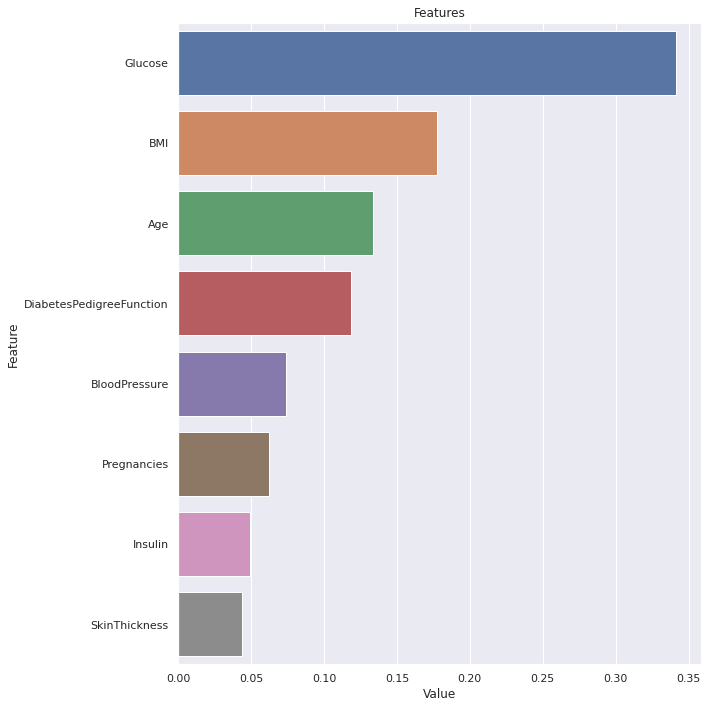

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

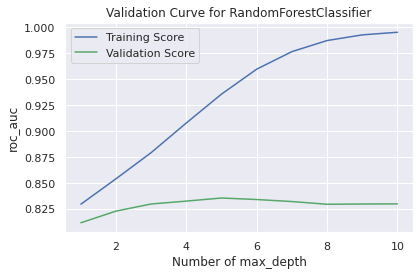

In [ ]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")

# GBM (Gradient Boosting Machines)

Artık optimizasyonuna göre çalışan bir ağaç yöntemidir. GBM in temelleri AdaBoost (Adaptive Boosting) a dayanır. AdaBoost: Zayıf sınıflandırıcıların bir araya gelerek güçlü bir sınıflandırıcı oluşturması fikrine dayanır.
GBM: Hatalar/Artıklar üzerine **tek** bir tahminsel model formunda olan modeller serisi kurulur (2001 Friedman).
* Boosting + Gradient Descent
* Gradient boosting tek bir tahminsel model formunda olan modeller serisi oluşturur. 
* Seri içerisindeki bir model serisindeki bir önceki modelin tahmin artıklarının/hatalarının (residuals) üzerine kurularak (fit) oluşturur.
* GBM diferensiyellenebilen herhangi bir kayıp fonksiyonunu optimize edebilen Gradient Descent algoritmasını kullanmaktadır.
* Tek bir tahminsel model formunda olan modeller serisi additive şekilde kurulur.

##Additive Modeling?

Ağaç yöntemlerinde şekli belli oranlara bölüyoruz, bunu daha hassaslaştırarak yapmak istersek additive model kullanıyoruz. (Detayı defterde)



In [ ]:
gbm_model = GradientBoostingClassifier(random_state=17)

gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7591715474068416

In [ ]:
cv_results['test_f1'].mean()

0.634235802826363

In [ ]:
cv_results['test_roc_auc'].mean()

0.8254867225716283

In [ ]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

In [ ]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
gbm_best_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.5}

In [ ]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)

In [ ]:
cv_results = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7774127832951362

In [ ]:
cv_results['test_f1'].mean()

0.6624630868272237

In [ ]:
cv_results['test_roc_auc'].mean()

0.8300300489168414

# XGBoost (XGBClassifier)

In [ ]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)
xgboost_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 17,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'use_label_encoder': False,
 'verbosity': 1}

In [ ]:
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7656820303879128

In [ ]:
cv_results['test_f1'].mean()

0.6459643958047878

In [ ]:
cv_results['test_roc_auc'].mean()

0.8295541579315163

In [ ]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

In [ ]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [ ]:
cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.7617774382480265

In [ ]:
cv_results['test_f1'].mean()

0.6135193047860682

In [ ]:
cv_results['test_roc_auc'].mean()

0.8235262054507337

### LightGBM

In [ ]:
lgbm_model = LGBMClassifier(random_state=17)
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [ ]:
cv_results['test_accuracy'].mean()

0.7487479840421016

In [ ]:
cv_results['test_f1'].mean()

0.6191041399705154

In [ ]:
cv_results['test_roc_auc'].mean()

0.8028567435359889

In [ ]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [ ]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [ ]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [ ]:
cv_results['test_accuracy'].mean()

0.764349376114082

In [ ]:
cv_results['test_f1'].mean()

0.6246212438290254

In [ ]:
cv_results['test_roc_auc'].mean()

0.8249930118798042

In [ ]:
# Hiperparametre yeni değerlerle
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

In [ ]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [ ]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [ ]:
cv_results['test_accuracy'].mean()

0.7656650539003481

In [ ]:
cv_results['test_f1'].mean()

0.6235412536580761

In [ ]:
cv_results['test_roc_auc'].mean()

0.8215443745632426

In [ ]:
# Hiperparametre optimizasyonu sadece n_estimators için.
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

In [ ]:
lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

In [ ]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [ ]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

In [ ]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()

0.763059163059163

In [ ]:
cv_results['test_f1'].mean()

0.6168442969188852

In [ ]:
cv_results['test_roc_auc'].mean()

0.8232976939203354

### CatBoost

In [ ]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()

0.7735251676428148

In [ ]:
cv_results['test_f1'].mean()

0.6502723851348231

In [ ]:
cv_results['test_roc_auc'].mean()

0.8378923829489867

In [ ]:
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

In [ ]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

In [ ]:
cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [ ]:
cv_results['test_accuracy'].mean()

0.7721755368814192

In [ ]:
cv_results['test_f1'].mean()

0.6322580676028952

In [ ]:
cv_results['test_roc_auc'].mean()

0.842001397624039